# Part I - (Dataset Exploration Title)
## by Charles Nikoro

## Introduction

In this project, I will analyze loan data from Prosper (a peear-to-peer lending marketplace) with the aim of investigating the possible factors that can affect the outcome of a loan's status.

> Introduce the dataset

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  



## Preliminary Wrangling


In [12]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [13]:
# load data and check the first five records

loans = pd.read_csv('../dataset/prosperLoanData.csv')

loans.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [3]:
print("Shape of the dataframe:", loans.shape)
print("Number of duplicate records:", loans.duplicated().sum())

Shape of the dataframe: (113937, 81)
Number of duplicate records: 0


In [6]:
# columns without null values

columns_without_null = loans.isna().sum()==0
loans.isna().sum()[columns_without_null].index

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'Term',
       'LoanStatus', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'DateCreditPulled', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanKey', 'LoanCurrentDaysDelinquent',
       'LoanMonthsSinceOrigination', 'LoanNumber', 'LoanOriginalAmount',
       'LoanOriginationDate', 'LoanOriginationQuarter', 'MemberKey',
       'MonthlyLoanPayment', 'LP_CustomerPayments',
       'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees',
       'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount',
       'Investors'],
      dtype='object')

In [7]:
# columns with null values

columns_with_null = loans.isna().sum()>0
loans.isna().sum()[columns_with_null].index

Index(['CreditGrade', 'ClosedDate', 'BorrowerAPR', 'EstimatedEffectiveYield',
       'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)',
       'ProsperRating (Alpha)', 'ProsperScore', 'BorrowerState', 'Occupation',
       'EmploymentStatus', 'EmploymentStatusDuration', 'GroupKey',
       'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'TotalProsperLoans', 'TotalProsperPaymentsBilled',
       'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate',
       'ProsperPaymentsOne

In [10]:
# columns and their data types

dtypes = ['bool', 'int64', 'float64', 'object']

for dtype in dtypes:
    print(f"{dtype}\n{set(loans.dtypes[loans.dtypes == dtype].index)}\n")

bool
{'IncomeVerifiable', 'CurrentlyInGroup', 'IsBorrowerHomeowner'}

int64
{'LoanNumber', 'LoanOriginalAmount', 'Investors', 'InvestmentFromFriendsCount', 'OpenRevolvingAccounts', 'LoanCurrentDaysDelinquent', 'ListingNumber', 'LoanMonthsSinceOrigination', 'Term', 'Recommendations', 'ListingCategory (numeric)'}

float64
{'ProsperRating (numeric)', 'LenderYield', 'TradesNeverDelinquent (percentage)', 'CreditScoreRangeUpper', 'BorrowerRate', 'CreditScoreRangeLower', 'BankcardUtilization', 'PublicRecordsLast10Years', 'MonthlyLoanPayment', 'LP_NonPrincipalRecoverypayments', 'LP_GrossPrincipalLoss', 'DebtToIncomeRatio', 'TotalTrades', 'EstimatedEffectiveYield', 'AmountDelinquent', 'LP_NetPrincipalLoss', 'LP_CustomerPayments', 'BorrowerAPR', 'LP_CollectionFees', 'TotalProsperPaymentsBilled', 'ProsperScore', 'OnTimeProsperPayments', 'ScorexChangeAtTimeOfListing', 'OpenRevolvingMonthlyPayment', 'OpenCreditLines', 'InquiriesLast6Months', 'InvestmentFromFriendsAmount', 'StatedMonthlyIncome', 'To

In [45]:
# summary statistics

loans.loc[:, 'Term':].describe()

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,113937.000000,...,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,2.774209,...,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,3.996797,...,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,0.000000,...,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,36.000000,0.156290,0.134000,0.124200,0.115670,0.042400,0.074080,3.000000,4.000000,1.000000,...,-73.180000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,36.000000,0.209760,0.184000,0.173000,0.161500,0.072400,0.091700,4.000000,6.000000,1.000000,...,-34.440000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,36.000000,0.283810,0.250000,0.240000,0.224300,0.112000,0.116600,5.000000,8.000000,3.000000,...,-13.920000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,115.000000
max,60.000000,0.512290,0.497500,0.492500,0.319900,0.366000,0.283700,7.000000,11.000000,20.000000,...,32.060000,0.000000,25000.000000,25000.000000,21117.900000,1.012500,39.000000,33.000000,25000.000000,1189.000000


In [125]:
loans.query('LoanCurrentDaysDelinquent==2704')[['LoanStatus', 'Term', 'ProsperPaymentsLessThanOneMonthLate']]

,LoanStatus,Term,ProsperPaymentsLessThanOneMonthLate
32889,Chargedoff,36,<NA>


In [97]:
loans[loans.CreditScoreRangeLower.isna()][['LoanStatus', 'TotalProsperLoans', 'OnTimeProsperPayments']].value_counts(dropna=False)

LoanStatus  TotalProsperLoans  OnTimeProsperPayments
Completed   <NA>               <NA>                     416
Defaulted   <NA>               <NA>                     126
Chargedoff  <NA>               <NA>                      48
Cancelled   <NA>               <NA>                       1
dtype: int64

In [95]:
print(loans.CreditScoreRangeLower.isna().sum())
print(loans.DebtToIncomeRatio.isna().sum())

591
8554


In [99]:
loans[['CreditScoreRangeLower', 'CreditScoreRangeUpper']].describe()

,CreditScoreRangeLower,CreditScoreRangeUpper
count,113346.000000,113346.000000
mean,685.567731,704.567731
std,66.458275,66.458275
min,0.000000,19.000000
25%,660.000000,679.000000
50%,680.000000,699.000000
75%,720.000000,739.000000
max,880.000000,899.000000


In [107]:
loans.query('CreditScoreRangeLower==0')['CreditScoreRangeUpper'].value_counts()

19.0    133
Name: CreditScoreRangeUpper, dtype: int64

In [113]:
loans[['LoanOriginalAmount', 'MemberKey']].loc[0]

LoanOriginalAmount                       9425
MemberKey             1F3E3376408759268057EDA
Name: 0, dtype: object

In [117]:
loans.MemberKey.value_counts()

63CA34120866140639431C9    9
4D9C3403302047712AD0CDD    8
7E1733653050264822FAA3D    8
16083364744933457E57FB9    8
C45F3365236450678BA344C    8
                          ..
F9AA35389429427911792C0    1
1A0D37000134574835A9BBC    1
B55D3695588654177197097    1
D4D0370361256969858E9F3    1
CE1E3704648000761C9F724    1
Name: MemberKey, Length: 90831, dtype: int64

In [86]:
loans.query('MemberKey=="63CA34120866140639431C9"')[['ListingCreationDate','LoanOriginalAmount',
 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'TotalProsperLoans', 'LoanStatus']].sort_values('ListingCreationDate')

,ListingCreationDate,LoanOriginalAmount,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,TotalProsperLoans,LoanStatus
112582,2008-05-11 08:50:35.250000000,2500,NaN,NaN,<NA>,Completed
79158,2008-06-26 08:46:11.957000000,5500,2500.0,0.00,1,Completed
34238,2008-10-03 23:08:28.973000000,7500,8000.0,0.00,2,Completed
93105,2009-05-02 07:42:03.340000000,1000,15500.0,0.00,3,Completed
59501,2009-11-03 17:17:22.967000000,1100,16500.0,0.00,4,Completed
113631,2010-05-08 11:41:37.433000000,2000,17600.0,0.02,5,Completed
40075,2011-07-19 12:22:18.127000000,7000,19600.0,0.02,6,Completed
21090,2012-09-01 13:10:38.800000000,10000,26600.0,4026.85,7,Completed
2787,2013-07-17 12:51:20.257000000,2200,36600.0,0.02,8,Current


In [121]:
loans.ProsperPrincipalOutstanding.isna().sum()

91852

In [123]:
loans.LP_InterestandFees.value_counts()

0.0000       6223
1521.6600      83
191.9500       56
1592.7200      53
1836.9500      48
             ... 
1654.6200       1
2547.0700       1
53.2500         1
851.1614        1
6122.5600       1
Name: LP_InterestandFees, Length: 78751, dtype: int64

In [110]:
loans[loans.CreditScoreRangeLower.isna()]['CreditScoreRangeUpper'].value_counts(dropna=False)

NaN    591
Name: CreditScoreRangeUpper, dtype: int64

In [90]:
# make ListingCategory (numeric) and Term of categorical types

category = pd.api.types.CategoricalDtype(categories=range(1,18), ordered=False)

loans['ListingCategory (numeric)'] = loans['ListingCategory (numeric)'].astype(category)

category = pd.api.types.CategoricalDtype(categories=[12, 36, 60], ordered=True)

loans['Term'] = loans.Term.astype(category)

# LoanStatus would be made an ordered categorical variable

category = ['Cancelled', 'Current', 'FinalPaymentInProgress', 'Completed',
 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 
'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (> 120 days)', 
'Defaulted', 'Chargedoff']

category = pd.api.types.CategoricalDtype(categories=category, ordered=True)
loans.LoanStatus = loans.LoanStatus.astype(category)

### What is the structure of your dataset?

The dataset comprises 113937 observations and 81 variables some of which contains null values. For some of them, it means that there are no existing records for the borrower concerned. For instance, according to the [data dictionary](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0), a borrower with a null `TotalProsperLoans` value doesn't have prior loans. The `ListingCategory (numeric)` variable is encoded as follows: 0 - Not Available, 1 - Debt Consolidation, 2 - Home 
Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic 
Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - 
Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in figuring out the features that will help predict the outcome of a borrower's loan status.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I suspect that the `LoanCurrentDaysDelinquent` variable might be an important factor to consider to determine if a borrower will default or not. Other factors I also intend to investigate includes the total number of prior loans (`TotalProsperLoans`), term of each loan (`Term`), principal outstanding of the borrower (`ProsperPrincipalOutstanding`), listing category (`ListingCategory (numeric)`), average credit score (`(CreditScoreRangeLower + CreditScoreRangeUpper) / 2`), percentage of the loan that was funded by investors (`PercentFunded`), percentage of on time payments made (`OnTimeProsperPayments / TotalProsperPaymentsBilled`), stated monthly income of the borrower (`StatedMonthlyIncome`) and whether they are verifiable or not (`IncomeVerifiable`), and the number of times the borrower was more than one month late on prior loans (`ProsperPaymentsOneMonthPlusLate`).



## Univariate Exploration

I'll begin by looking at the distribution of the main variable of interest – `LoanStatus`.

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


##### Which loan status has the highest frequency count?

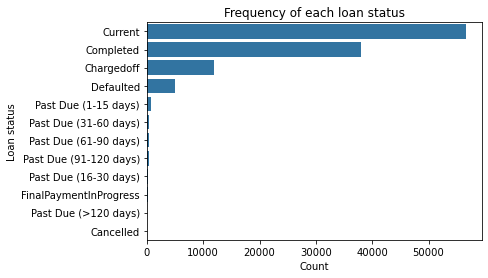

In [141]:
# plot distribution of LoanStatus

sns.countplot(data=loans, y='LoanStatus', order=loans.LoanStatus.value_counts().index, color=sns.color_palette()[0])
plt.xlabel('Count')
plt.ylabel('Loan status')
plt.title('Frequency of each loan status')
plt.show()

From the above chart, we can see that there are more borrowers with a current loan status while a significantly small number of them had their loans cancelled. Let's confirm this with a call to `value_counts()`.

In [ ]:
loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Cancelled                     5
Past Due (> 120 days)         0
Name: LoanStatus, dtype: int64

As we can see, there are 5 borrowers with a cancelled loan and none with loans that are more than 120 days past due. We will therefore remove this option from the list of values of this variable.

In [106]:
category = ['Cancelled', 'Current', 'FinalPaymentInProgress', 'Completed',
 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 
'Past Due (61-90 days)', 'Past Due (91-120 days)', 
'Defaulted', 'Chargedoff']

category = pd.api.types.CategoricalDtype(categories=category, ordered=True)
loans.LoanStatus = loans.LoanStatus.astype(category)

loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Cancelled                     5
Name: LoanStatus, dtype: int64

Next, let's take a look at the distribution of the stated monthly income. First, we will define two functions for computing the number of bins we need for the plot and for performing a log transformation of the `StatedMonthlyIncome` variable because of its large values.

In [15]:
def get_bin_counts(series):
    """
       computes number of bins needed to plot the histogram of series
       using Freedman Diaconis algorithm
       
       :param series: quantitative pandas series
       :return integer: the number of bins
    """
    bin_width = 2*((series.quantile(0.75)-series.quantile(0.25))/(np.power(series.shape[0],1/3)))
    return ((series.max()-series.min())//bin_width).astype(int)

def log_trans(number):
    '''
        computes the log of a number

        :param integer: number whose log we want to compute
        :return float: log of the number
    '''

    if not number: # return 0 if number is 0
        return 0
    return math.log10(number)

##### What is the distribution of the Stated Monthly Income of the borrowers? Do most of them have documents to support their stated income?

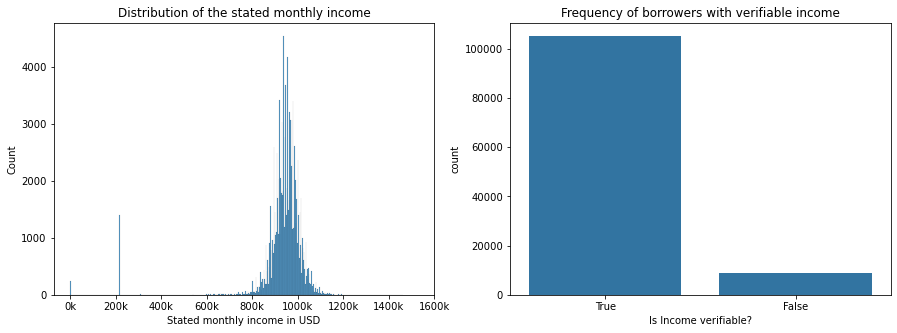

In [134]:
# distribution of monthly income

log_of_income = loans.StatedMonthlyIncome.apply(log_trans) # perform log transform on the monthly income

fig,axs = plt.subplots(1,2,figsize=(15,5))

xticklabels = ['0k', '200k', '400k', '600k', '800k', '1000k', '1200k', '1400k', '1600k']
xticks = np.arange(log_of_income.min(), log_of_income.max()+1)

ax1 = sns.histplot(log_of_income, bins = get_bin_counts(log_of_income), ax=axs[0])
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
ax1.set(xlabel='Stated monthly income in USD',
        title='Distribution of the stated monthly income')

# distribution of borrowers with verifiable income

ax2 = sns.countplot(data=loans, x='IncomeVerifiable', color=sns.color_palette()[0], order=loans.IncomeVerifiable.value_counts().index, ax=axs[1])
ax2.set(xlabel="Is Income verifiable?",
        title="Frequency of borrowers with verifiable income")

plt.show()

The stated monthly income follows a roughly normal distribution with most borrowers having their income between $850,000 and $950,000. As we can also see, most of the borrowers have supporting documents to verify their income. Let's take a look at the distribution of the `LoanCurrentDaysDelinquent` variable.

##### What is the distribution of the number of days the borrowers were delinquent on a loan? Is it roughly the same as the number of times the borrower was more than one month late on prior loans?

Because the interquantile range of `LoanCurrentDaysDelinquent` and `ProsperPaymentsOneMonthPlusLate` are both 0, we can't use the Freedman Diaconis algorithm that `get_bin_counts()` is based on to compute their optimal bin size to use. We will have to manually compute their bin edges. The `ProsperPaymentsOneMonthPLusLate` variable also contains null values which implies that the borrower didn't have any prior loans. We will replace these values with 0. We will also plot the y-axis on a log scale in order to make every bin visible.

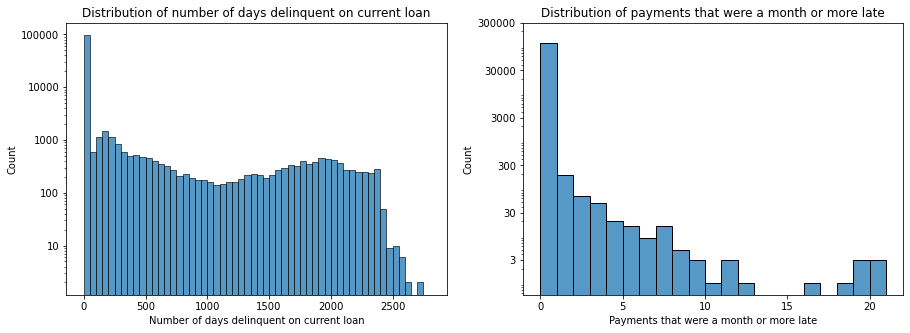

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

# distribution of LoanCurrentDaysDelinquent

bin_edges = np.arange(loans.LoanCurrentDaysDelinquent.min(), loans.LoanCurrentDaysDelinquent.max()+100, 50)
ax1_ticks = [10, 100, 1000, 10000, 100000]
ax1_labels = [str(i) for i in ax1_ticks]

ax1 = sns.histplot(data=loans, x='LoanCurrentDaysDelinquent', bins=bin_edges, ax=axes[0])
ax1.set_yscale('log')
ax1.set_yticks(ticks=ax1_ticks)
ax1.set_yticklabels(ax1_labels)
ax1.set(xlabel="Number of days delinquent on current loan",
        title="Distribution of number of days delinquent on current loan")

# distribution of ProsperPaymentsOneMonthPlusLate
loans.ProsperPaymentsOneMonthPlusLate = loans.ProsperPaymentsOneMonthPlusLate.fillna(0)

bin_edges = np.arange(loans.ProsperPaymentsOneMonthPlusLate.min(), loans.ProsperPaymentsOneMonthPlusLate.max()+1)
ax2_ticks = [3, 30, 300, 3000, 30000, 300000]
ax2_labels = [str(i) for i in ax2_ticks]

ax2 = sns.histplot(x=loans.ProsperPaymentsOneMonthPlusLate, bins=bin_edges, ax=axes[1])
ax2.set_yscale('log')
ax2.set_yticks(ticks=ax2_ticks)
ax2.set_yticklabels(ax2_labels)
ax2.set(xlabel="Payments that were a month or more late",
        title="Distribution of payments that were a month or more late")
        
plt.show()


The distribution of both variables is skewed to the right. That of the `LoanCurrentDaysDelinquent` variable peeks roughly between 0 and 30 days. This means that most borrowers where delinquent on their payments for at most a month. On the other hand, the distribution of the `ProsperPaymentsOneMonthPlusLate` variable shows that there are more borrowers that delay their payments for about 1 to 3 months.

##### What is the distribution of the total number of loans? Which listing category and term did most of the borrowers decide to opt for?

Since the total number of Prosper loans taken by each borrower is discrete with a fairly small range of values, we can use a bar plot to get a sense of its distribution. The `TotalProsperLoans` variable also contains null values which means that the borrower had no prior prosper loan. We will replace these values with 0.

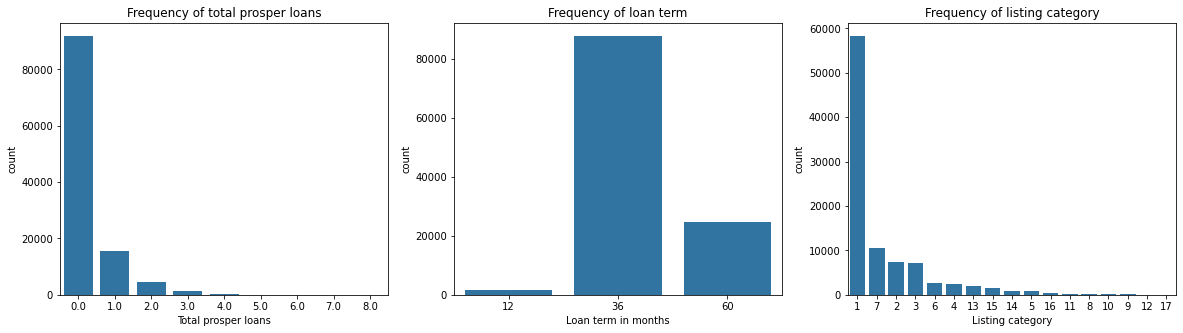

In [107]:
# Distribution of TotalProsperLoans, Term, and ListingCategory

fig, axes = plt.subplots(1,3, figsize=(20,5))

loans.TotalProsperLoans = loans.TotalProsperLoans.fillna(0)

ax1 = sns.countplot(data=loans, x='TotalProsperLoans', color=sns.color_palette()[0], ax=axes[0], order=loans.TotalProsperLoans.value_counts().index)
ax1.set(xlabel="Total prosper loans",
        title="Frequency of total prosper loans")

ax2 = sns.countplot(data=loans, x='Term', color=sns.color_palette()[0], ax=axes[1])
ax2.set(xlabel="Loan term in months",
        title='Frequency of loan term')

ax3 = sns.countplot(data=loans, x='ListingCategory (numeric)', color=sns.color_palette()[0], ax=axes[2],
 order=loans['ListingCategory (numeric)'].value_counts().index)

ax3.set(xlabel="Listing category",
        title="Frequency of listing category")


plt.show()

From the plots, most borrowers had no prior Prosper loans, most of their loans were for a 3-year term, and most of them took loans for debt consolidation which is represented as 1 in the `ListCategory (numeric)` variable.

##### What is the distribution of the percentage of on time payments made?

The `OnTimeProsperPayments` and `TotalProsperPaymentsBilled` variables both have null values that implies that the borrower concerned doesn't have any prior loans. In such case, the record will have a null percentage of on time payments. We will replace the null value with 0. We will also plot the y-axis on a log scale in other to make every bin visible.

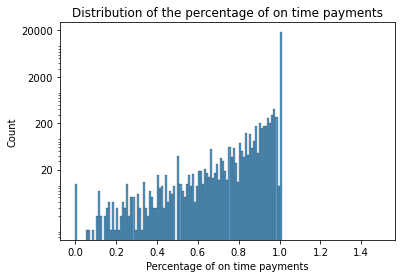

In [18]:
# compute the percentages of On time payments
loans['PercentOnTimePayment'] = loans.OnTimeProsperPayments / loans.TotalProsperPaymentsBilled
loans.drop(columns=['OnTimeProsperPayments', 'TotalProsperPaymentsBilled'], inplace=True)

bin_edges = np.arange(0, loans.PercentOnTimePayment.max()+0.5, 0.01)

sns.histplot(data=loans, x='PercentOnTimePayment', bins=bin_edges)
plt.yscale('log')
plt.yticks([20,200,2000,20000], ['20', '200', '2000', '20000'])
plt.xlabel('Percentage of on time payments')
plt.title('Distribution of the percentage of on time payments')

plt.show();

The distribution is unimodal and skewed to the left. It shows that most borrowers had 100% on time payments.

##### What is the distribution of `ProsperPrincipalOutstanding`? What is also the distribution of the average credit score?

As with the `TotalProsperLoans` variable, `ProsperPrincipalOutstanding`, `CreditScoreRangeLower`, and `CreditScoreRangeUpper` also contains null values that mean the borrowers concerned didn't have any prior loans. We will also replace them with 0. A log scale will be used on the y-axis to make the bins of the distribution of `ProsperPrincipalOutstanding` visible.

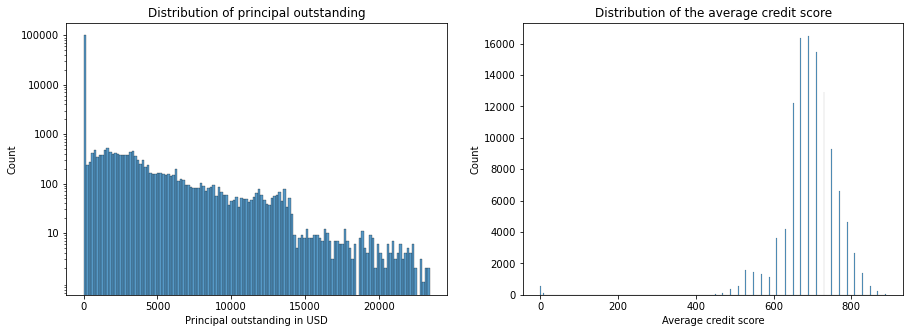

In [19]:
# distribution of ProsperPrincipalOutstanding

fig, axes = plt.subplots(1,2, figsize=(15,5))

bin_size = get_bin_counts(loans.ProsperPrincipalOutstanding)

loans.ProsperPrincipalOutstanding = loans.ProsperPrincipalOutstanding.fillna(0)

ax1 = sns.histplot(data=loans, x='ProsperPrincipalOutstanding', bins=bin_size, ax=axes[0]) 
ax1.set_yscale('log')
y_ticks = [10, 100, 1000, 10000, 100000]
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([str(i) for i in y_ticks])
ax1.set(xlabel="Principal outstanding in USD",
       title="Distribution of principal outstanding")

loans['AverageCreditScore'] = (loans.CreditScoreRangeUpper.fillna(0) + loans.CreditScoreRangeLower.fillna(0))/2
loans.drop(columns=['CreditScoreRangeLower', 'CreditScoreRangeUpper'], inplace=True)

ax2 = sns.histplot(data=loans, x='AverageCreditScore', bins=get_bin_counts(loans.AverageCreditScore), ax=axes[1])
ax2.set(xlabel='Average credit score',
        title='Distribution of the average credit score')

plt.show()

The distribution is unimodal with a peak between 0 and 700 dollars. The distribution seems to decrease with an increase in the principal outstanding which suggests that there are less borrowers with a lot of outstanding that those with few. On the other hand, the average credit score roughly follows a normal distribution with a peak around 700.

##### What is the distribution of the percentage of the loan that was funded?

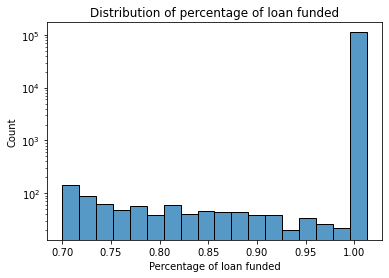

In [140]:
# distribution of the PercentFunded


sns.histplot(data=loans, x='PercentFunded')
plt.yscale('log')
plt.xlabel('Percentage of loan funded')
plt.title('Distribution of percentage of loan funded')
plt.show();

This distribution is also unimodal with most of the loans having 100% funding.



>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

I created two new columns – `AverageCreditScore` and `PercentOnTimePayment` – in the dataframe. The former is the average credit score of `CreditScoreRangeLower` and `CreditScoreRangeUpper` while the latter is the percentage of `OnTimeProsperPayments` in `TotalProsperPaymentsBilled`. The `CreditScoreRangeLower`, `CreditScoreRangeUpper`, `OnTimeProsperPayments`, and `TotalProsperPaymentsBilled` were then dropped. I did a log transformation of `MonthlyStatedIncome` due to its large range of values, and also plotted the distributions of `LoanCurrentDaysDelinquent`, `ProsperPaymentsOneMonthPlusLate`, `ProsperPrincipalOutstanding`, `AverageCreditScore`, and `PercentFunded` on a log scale for their y-axis to make their bins visible. I also replaced the null values in the variables with 0 since a null value in these cases means the borrower had no prior loan.

Most of the loans in the dataset are current with very few of them been cancelled as shown in the bar plot of `LoanStatus`. The stated monthly income follows a normal distribution and the bar plot of the `IncomeVerifiable` variable shows that most of them can be verified. The distribution of the number of days borrowers were delinquent on their current loan, payments that were a month or more late, and the principal outstanding are unimodal and roughly skewed to the right with a peak between 0 and 30 days for `LoanCurrentDaysDelinquent`, 1 and 3 months for `ProsperPaymentsOneMonthPlusLate`, and 0 and 700 dollars for `ProsperPrincipalOutstanding` respectively. The percentage of on time payments as well as the percentage of the loan that was funded are also unimodal, but they are left skewed with a peak around 100% in both cases. The average credit score follows a normal distribution with a peak around 700.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I noticed that there were no borrowers with a `Past Due(> 120 days)` status. I decided to remove this option from the list of possible values for the `LoanStatus` variable, since it won't be useful in our current analysis.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

##### Is there a relationship between average credit score and principal outstanding balance?

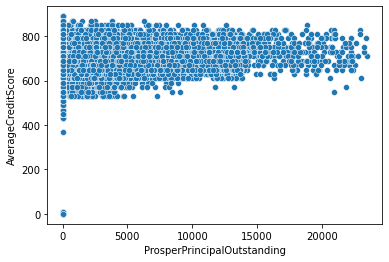

In [114]:
# we will investigate this with a scatter plot

sns.scatterplot(data=loans, x='ProsperPrincipalOutstanding', y='AverageCreditScore')
plt.show()

There seems to be little or no relationship between the average credit score and the principal outstanding balance. There is one rather extreme value in the plot – the case where some borrowers have an average of 0 credit score and a 0 principal outstanding balance. Their loan might have been cancelled.

##### Which loan status has the most principal outstanding?

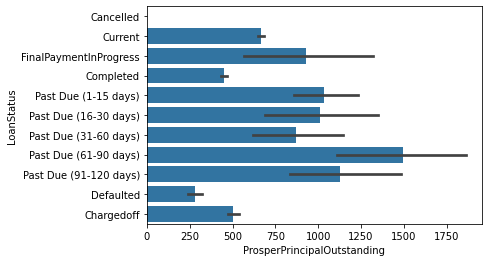

In [108]:
# we will investigate this with a bar plot with the mean of the prosper principal outstanding on the x-axis

sns.barplot(data=loans, x='ProsperPrincipalOutstanding', y='LoanStatus', color=sns.color_palette()[0])

plt.show()

It turns out that the `Past Due (61-90 days)` status has the largest principal outstanding. As we suspected above, borrowers whose loans were cancelled have no principal outstanding.

##### Is there a relationship between average credit score and percentage of on time payments?

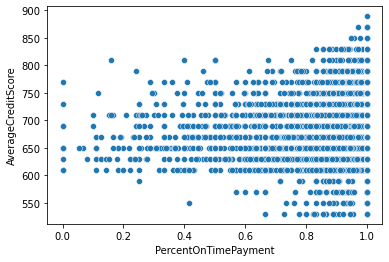

In [58]:
# We will investigate this with a scatter plot

sns.scatterplot(data=loans, x='PercentOnTimePayment', y='AverageCreditScore')

plt.show()

There seem to be a very weak negative relationship between the average credit score and the percentage of on time payments.

##### Is there a relationship between the percentage of on time payments and the principal outstanding?

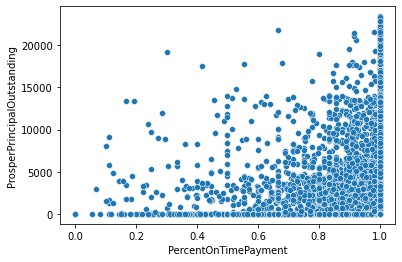

In [81]:
# We will investigate this with a scatter plot

sns.scatterplot(data=loans, x='PercentOnTimePayment', y='ProsperPrincipalOutstanding')

plt.show()

##### Which loan status has the least average stated monthly income?

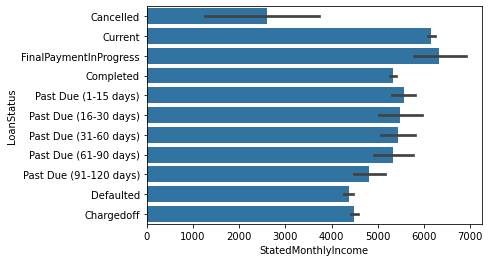

In [109]:
# we will investigate this with a bar plot with the mean of StatedMonthlyIncome on the x-axis

sns.barplot(data=loans, x='StatedMonthlyIncome', y='LoanStatus', color=sns.color_palette()[0])

plt.show()

It looks like cancelled loans have the lowest stated monthly income on average. This is followed with loans that were defaulted and charged off.

##### Is there a relationship between the number of days borrowers were delinquent and the loan status?

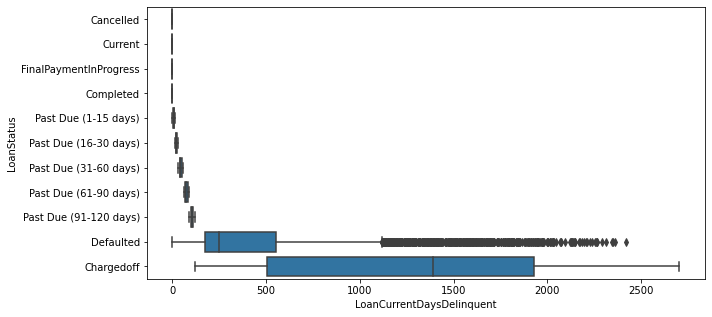

In [110]:
# we will investigate this with a box plot

plt.figure(figsize=(10,5))

sns.boxplot(data=loans, x='LoanCurrentDaysDelinquent', y='LoanStatus', color=sns.color_palette()[0])

plt.show()

The plot shows that there seems to be a relationship between these variables as we would expect. Borrowers whose loan status are either `Current`, `Completed`, `FinalPaymentInProgress`, or `Cancelled` were not delinquent on their loans. Those with `Past Due (1-15 days)`, `Past Due (16-30 days)`, `Past Due (31-60 days)`, `Past Due (61-90 days)`, `Past Due (91-120 days)`, `Defaulted`, and `Chargedoff` statuses were delinquent for a number of days with `Chargedoff` having the highest number of delinquent days which is expected. It's median is between 1300 and 1500 days.

##### Are borrowers with more prior loans less likely to be charged off?

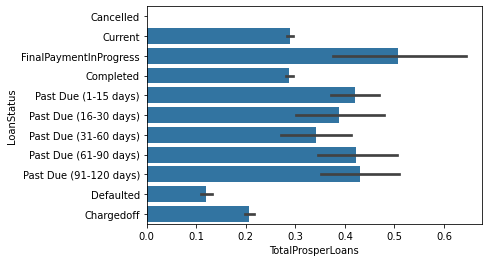

In [111]:
# we will investigate this using a bar plot with the mean of TotalProsperLoans on the x-axis

sns.barplot(data=loans, x='TotalProsperLoans', y='LoanStatus', color=sns.color_palette()[0])

plt.show()

From the plot, it seems borrowers with `Cancelled`, `Defaulted`, and `Chargedoff` statuses have less number of prior loans. Consequently, it is less likely for borrowers with more prior loans to default or get charged off.

##### Are borrowers with verifiable income less likely to default?

We will investigate this with a clustered bar plot.

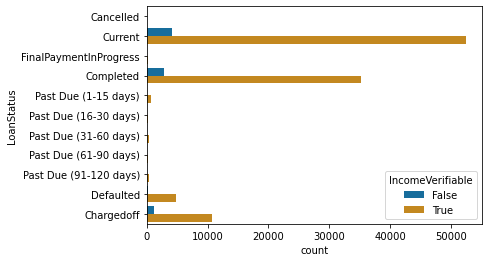

In [115]:
# bar plot of showing LoanStatus categorized according to whether borrowers have verifiable income.

sns.countplot(data=loans, y='LoanStatus', hue='IncomeVerifiable', palette='colorblind')

plt.show()

From the plot, we can see that few borrowers with verifiable income default or have their loan charged off. However, we also see a roughly similar trend with borrowers that didn't provide documents to support their stated income.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

